## Introduction
This notebook looks at an existing gradient boosting model and attempts to enhcance the accuracy by one of the following ways:  
- Creating new features
- Applying more overfitting-prevention strategies like subsampling
- More iterations
- Trying a different loss function
- Changing the structure of the weak learner: Allowing more leaves in the tree, or other modifications  

The data is from the European Social Survey Data.  In this case, we are trying to **predict the categorical outcome:  whether or not someone lives with a partner**.

In [1]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import ensemble
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
%matplotlib inline

## Importing and cleaning the data  
The training data uses 90% of the overall data while 10% remains to test.

In [2]:
df = pd.read_csv((
    "https://raw.githubusercontent.com/Thinkful-Ed/data-201-resources/"
    "master/ESS_practice_data/ESSdata_Thinkful.csv")).dropna()

# Definine outcome and predictors.
# Set our outcome to 0 and 1.
y = df['partner'] - 1
X = df.loc[:, ~df.columns.isin(['partner', 'cntry', 'idno'])]

# Make the categorical variable 'country' into dummies.
X = pd.concat([X, pd.get_dummies(df['cntry'])], axis=1)

# Create training and test sets.
offset = int(X.shape[0] * 0.9)

# Put 90% of the data in the training set.
X_train, y_train = X[:offset], y[:offset]

# And put 10% in the test set.
X_test, y_test = X[offset:], y[offset:]

A value of 1.0 in the 'partner' column meens that the person: lives with husband/wife/partner at household.  
A value of 2.0 means that the person: Does Not.  
For our y value, or dependent variable, we subtract 1 from the 'partner' column to obtain a value of 0 or 1.

In [3]:
df.head()

,cntry,idno,year,tvtot,ppltrst,pplfair,pplhlp,happy,sclmeet,sclact,gndr,agea,partner
0,CH,5.0,6,3.0,3.0,10.0,5.0,8.0,5.0,4.0,2.0,60.0,1.0
1,CH,25.0,6,6.0,5.0,7.0,5.0,9.0,3.0,2.0,2.0,59.0,1.0
2,CH,26.0,6,1.0,8.0,8.0,8.0,7.0,6.0,3.0,1.0,24.0,2.0
3,CH,28.0,6,4.0,6.0,6.0,7.0,10.0,6.0,2.0,2.0,64.0,1.0
4,CH,29.0,6,5.0,6.0,7.0,5.0,8.0,7.0,2.0,2.0,55.0,1.0


In [4]:
df.tail()

,cntry,idno,year,tvtot,ppltrst,pplfair,pplhlp,happy,sclmeet,sclact,gndr,agea,partner
8589,SE,3729.0,7,3.0,4.0,5.0,3.0,6.0,6.0,2.0,1.0,18.0,2.0
8590,SE,3732.0,7,5.0,6.0,4.0,4.0,10.0,6.0,3.0,1.0,15.0,2.0
8591,SE,3743.0,7,4.0,5.0,7.0,6.0,8.0,6.0,3.0,1.0,44.0,2.0
8592,SE,3744.0,7,5.0,8.0,8.0,6.0,9.0,7.0,3.0,1.0,15.0,2.0
8593,SE,3746.0,7,2.0,6.0,7.0,5.0,7.0,7.0,4.0,2.0,15.0,2.0


## Data exploration

In [5]:
df_explore = df.drop(['cntry', 'idno', 'year'], axis=1)

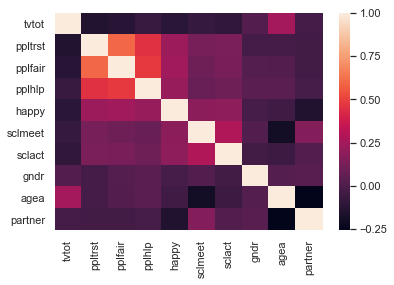

In [6]:
sns.set(font_scale=1.0)
sns.heatmap(df_explore.corr())

This is good.  Most of the features have very low correlation, so almost all are likely helpful predictors.

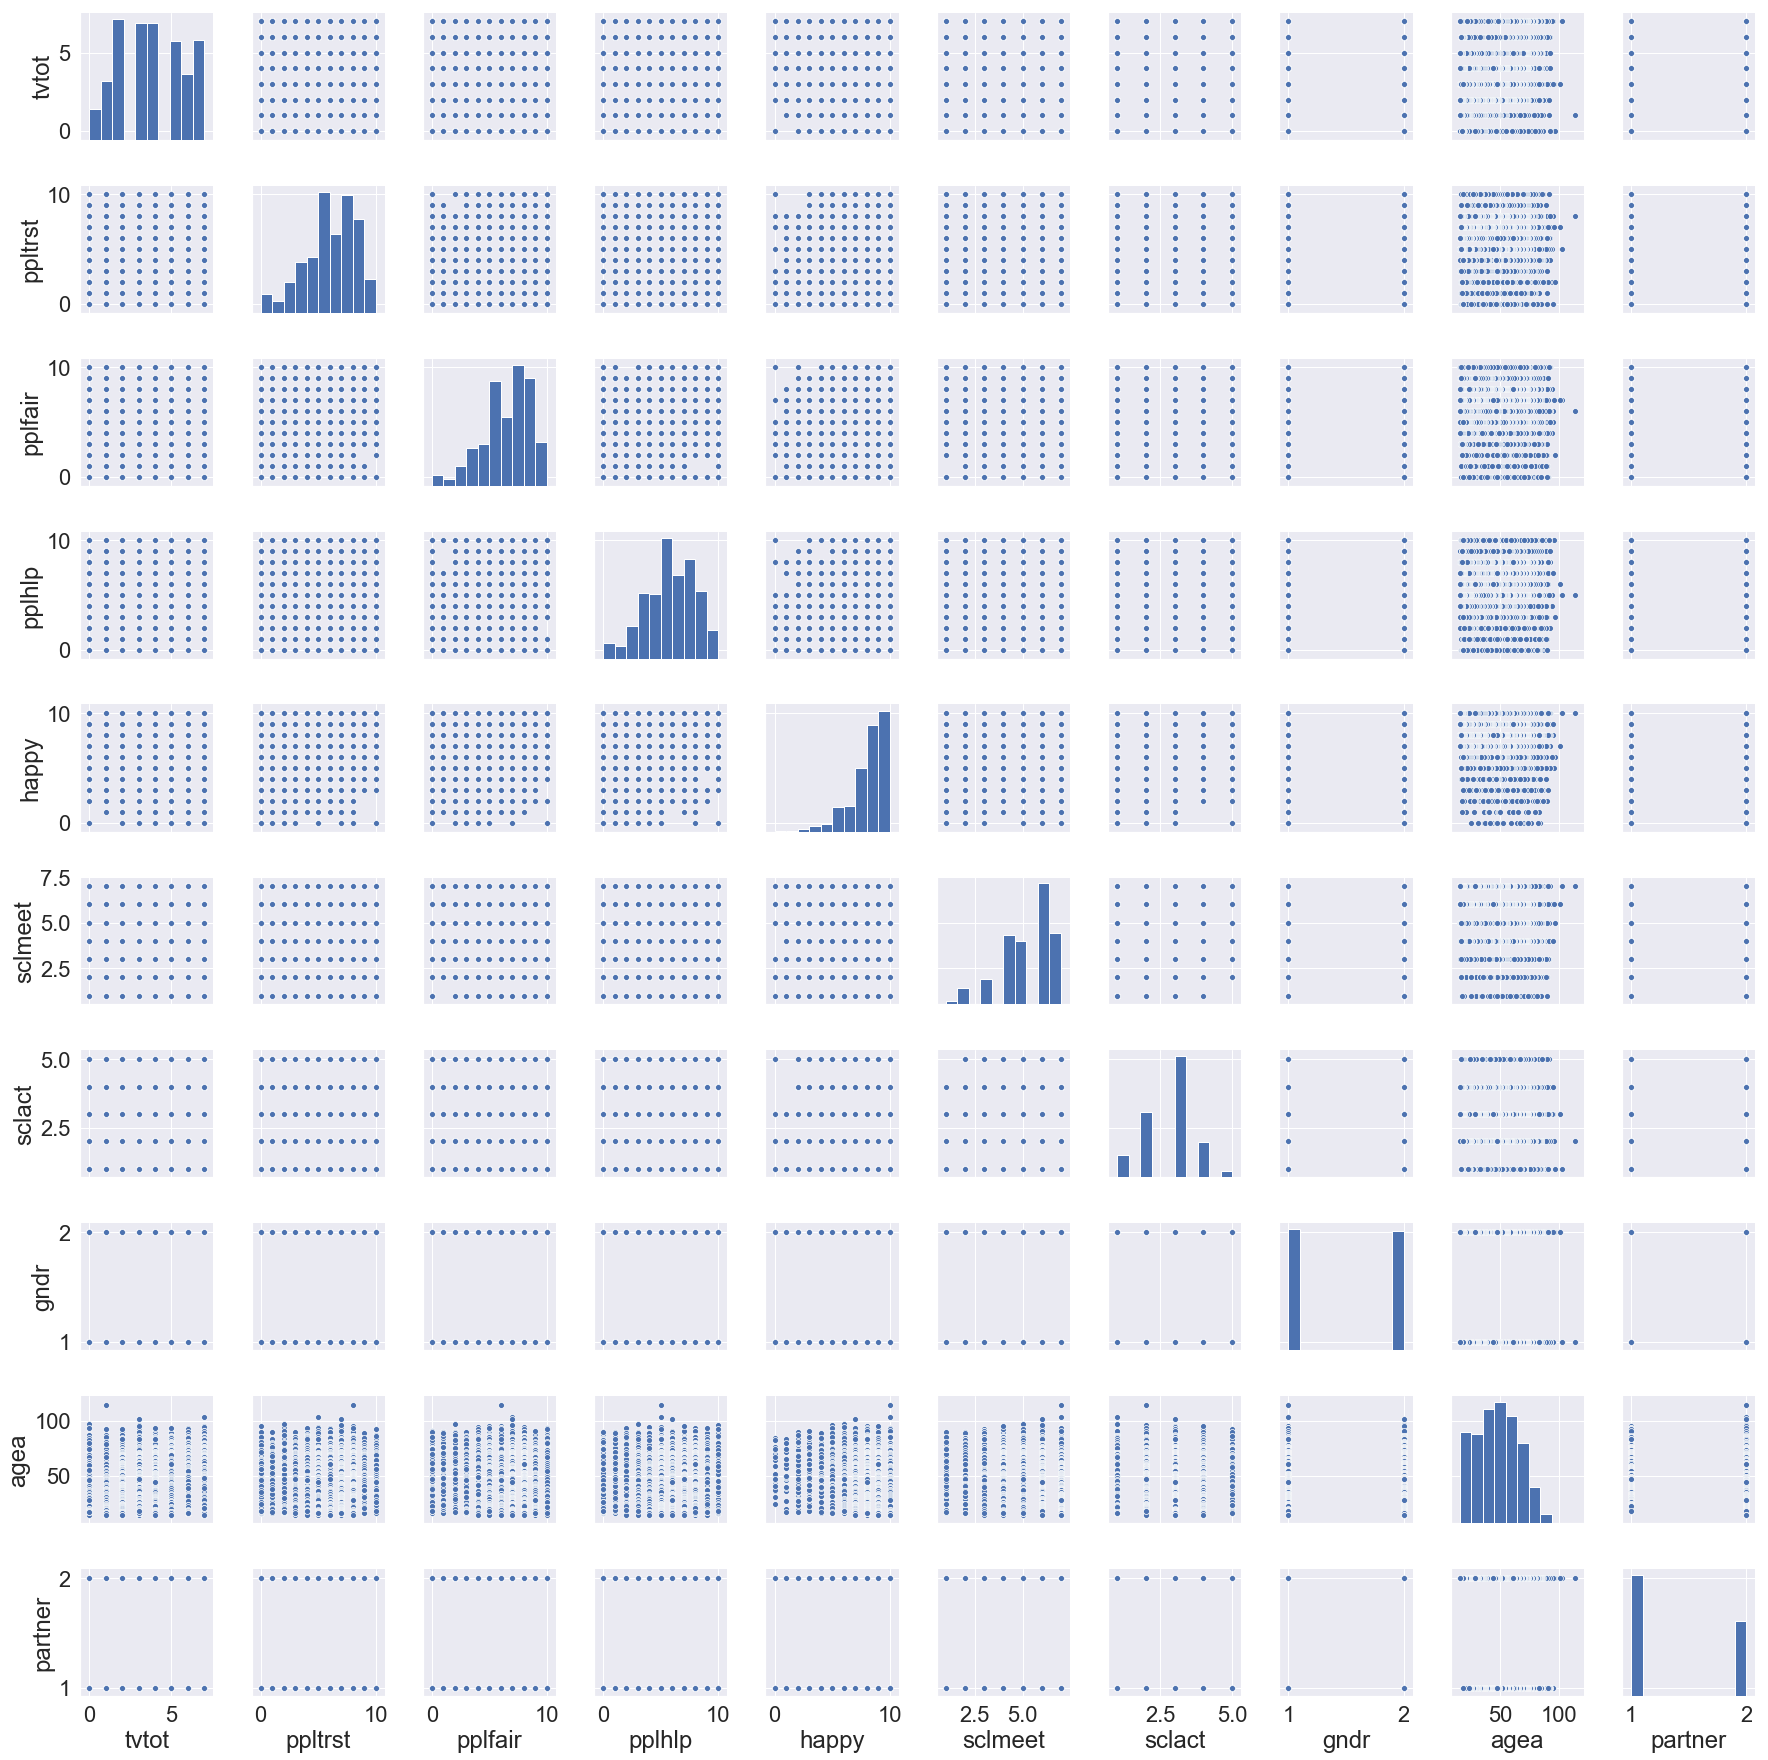

In [7]:
sns.set(font_scale=2.0)
sns.pairplot(df_explore)

Nothing too significant stands out in this pairplot.  

In [8]:
df.dtypes


cntry       object
idno       float64
year         int64
tvtot      float64
ppltrst    float64
pplfair    float64
pplhlp     float64
happy      float64
sclmeet    float64
sclact     float64
gndr       float64
agea       float64
partner    float64
dtype: object

## Building the model  
This first model is the model given to us in the course curriculum.  The next model is our attempt to improve the accuracy.

In [9]:
# We'll make 500 iterations, use 2-deep trees, and set our loss function.
params = {'n_estimators': 500,
          'max_depth': 2,
          'loss': 'deviance'}

# Initialize and fit the model.
clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(X_train, y_train)

predict_train = clf.predict(X_train)
predict_test = clf.predict(X_test)

# Accuracy tables.
table_train = pd.crosstab(y_train, predict_train, margins=True)
table_test = pd.crosstab(y_test, predict_test, margins=True)

train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))


Training set accuracy:
Percent Type I errors: 0.04650845608292417
Percent Type II errors: 0.17607746863066012

Test set accuracy:
Percent Type I errors: 0.06257668711656442
Percent Type II errors: 0.18527607361963191


2nd model:  Re-run the model; however, this time randomly select 60% for training data and 40% for test data.

In [10]:
# Create training and test sets.
num_60 = int(X.shape[0] * 0.6)
num_40 = int(X.shape[0] * 0.4)

X_train = X.sample(num_60)
y_train = y.sample(num_60)

X_test = X.sample(num_40)
y_test = y.sample(num_40)

# We'll make 500 iterations, use 2-deep trees, and set our loss function.
params = {'n_estimators': 1000,
          'max_depth': 3,
          'loss': 'deviance'}

# Initialize and fit the model.
clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(X_train, y_train)

predict_train = clf.predict(X_train)
predict_test = clf.predict(X_test)

# Accuracy tables.
table_train = pd.crosstab(y_train, predict_train, margins=True)
table_test = pd.crosstab(y_test, predict_test, margins=True)

train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))


Training set accuracy:
Percent Type I errors: 0.03375613747954174
Percent Type II errors: 0.19353518821603927

Test set accuracy:
Percent Type I errors: 0.14303253529772866
Percent Type II errors: 0.2946593001841621


## Evaluating the model  


**1st model** (given):  
Training set accuracy:  
Percent Type I errors: 0.04650845608292417  
Percent Type II errors: 0.17607746863066012  

Test set accuracy:  
Percent Type I errors: 0.06257668711656442  
Percent Type II errors: 0.18527607361963191  

**2nd model**:  
Training set accuracy:  
Percent Type I errors: 0.034  
Percent Type II errors: 0.194  

Test set accuracy:  
Percent Type I errors: **0.143**  
Percent Type II errors: **0.30**

## Conclusion and discussion

Several different methods were eperimented with in order to increase the accuracy of the model.  Changing the 'n_estimators', 'max_depth', or 'loss' method did not significantly alter the results.  
- n_estimators:  The number of boosting stages to perform.  
- max_depth:  Maximum depth of the individual regression estimators.  
- loss:  Loss function to be optimized. (deviance or exponential)

The most notable change was obtained by **randomly sampling 60%** for the training set instead of using the first 90% of the data (as in the first/given model).  This yielded an accuracy level of about **twice as good** as the original model for the test set.